# U-net para la identificación de imágenes segmentadas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
%cd /content/drive/My Drive/
!pwd
os.chdir('/content/drive/MyDrive/Colab Notebooks/YoloV5')
!pwd

/content/drive/My Drive
/content/drive/My Drive
/content/drive/MyDrive/Colab Notebooks/PyTorch/UNet/data/SegmentacionSemantica


## Paquetes

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.io import read_file, decode_jpeg, decode_png, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
from os import listdir

## Función de división de las imágenes en datos y etiquetas

Para poder ejecutar esta celda, tenemos que haber creado dentro de SegmentacionSemantica una carpeta llamada **ImagenesMonedas**, y dentro de ella meter los archivos descargados de Roboflow (carpetas train, valid, test, y ficheros README.roboflow.txt y README.dataset.txt

In [ ]:
import shutil
import os

# Previamente tendremos que haber creado la carpeta ImagenesMonedas,
# y haber metido en ellas las carpetas salidas de roboflow.


# Si no existe la carpeta labels, la creamos.
if not os.path.isdir('./ImagenesMonedas/labels'):
    os.mkdir('./ImagenesMonedas/labels')
    print("")


image_sets = ['train', 'valid', 'test']
for image_set in image_sets:

  # Creación de los directorios de datos y etiquetas, si no existen los creamos
  if not os.path.isdir('./ImagenesMonedas/' + image_set + '/images'):
    os.mkdir('./ImagenesMonedas/' + image_set + '/images')

  # Para cada imagen, si no es un directorio y no es un csv (el de las clases) la podemos mover (evitamos el problema de intentar mover el propio directorio de datos o etiquetas dentro de sí mismo)
  for image in os.listdir('./ImagenesMonedas/' + image_set):
    if not os.path.isdir('ImagenesMonedas/' + image_set + '/' + image) and '.csv' not in image:
      if '_mask' in image: # Si es una etiqueta, la movemos a labels. Si no, se queda en la carpeta en que está.
        shutil.move('ImagenesMonedas/' + image_set + '/' + os.path.splitext(image)[0] + '.png', 'ImagenesMonedas/labels/' + os.path.splitext(image)[0] + '.png')
      else:
        shutil.move('ImagenesMonedas/' + image_set + '/' + os.path.splitext(image)[0] + '.png', 'ImagenesMonedas/' + image_set + '/images/' + os.path.splitext(image)[0] + '.png')

#print(os.listdir("."))

## Creación de los directorios de test y sus etiquetas

Antes de ejecutar esta celda deberemos esperar (recomendado un minuto) a que se acabe de hacer el movimiento de imágenes de la anterior celda, si no se había hecho antes.

In [ ]:
# DATASET
import os

# read dataset for u-net
class Dataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.files = [os.path.splitext(f)[0] for f in os.listdir(data_dir)]
        self.transform = T.Resize((512, 512))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        # read image
        image = read_image(os.path.join(self.data_dir, file_name + ".png"), mode=ImageReadMode.RGB)
        
        # read mask
        mask = read_image(os.path.join(self.label_dir, file_name + "_mask.png"), mode=ImageReadMode.GRAY)
        
        # resize
        image = self.transform(image)
        mask = self.transform(mask)
        
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        # print(torch.min(image), torch.max(image))   # 0,255
        # print(torch.min(mask), torch.max(mask))     # 0,1
        
        image = image / 255.0
        # mask /= 255.0   # Si comentamos esta línea, los 2 print de abajo nos salen 0,1 0,1, que es lo que realmente queremos
        mask = torch.round(mask)

        # print(torch.min(image), torch.max(image))   # 0,1
        # print(torch.min(mask), torch.max(mask))     # 0,0

        return image, mask
        

        
ds = Dataset("./ImagenesMonedas/train/images", "./ImagenesMonedas/labels")
#print(ds.files)
ds_loader = DataLoader(ds, batch_size=4)

## UNet

In [ ]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = torch.randn((2, 3, 512, 512)).to(device)
model = build_unet().to(device)
y = model(inputs)
print(y.shape)

torch.Size([2, 1, 512, 512])


### Función de pérdida de la UNet

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

## Entrenamiento de la UNet

Para hacer una traza de la pérdida, usaremos el servicio we **wandb**, podremos así ver cómo la pérdida disminuye con el paso de los epoch.
¿Es posible que tengamos que hacer wandb login desde la terminal cada vez que queramos ejecutar lo de abajo?

In [ ]:
!pip install wandb -qU
# 028578a8cb1adb62def3213c0ca91880b94cc81f

     |████████████████████████████████| 1.9 MB 31.7 MB/s 
     |████████████████████████████████| 182 kB 72.4 MB/s 
     |████████████████████████████████| 168 kB 69.0 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 168 kB 76.7 MB/s 
     |████████████████████████████████| 166 kB 76.5 MB/s 
     |████████████████████████████████| 166 kB 82.4 MB/s 
     |████████████████████████████████| 162 kB 80.7 MB/s 
     |████████████████████████████████| 162 kB 76.4 MB/s 
     |████████████████████████████████| 158 kB 79.3 MB/s 
     |████████████████████████████████| 157 kB 82.2 MB/s 
     |████████████████████████████████| 157 kB 78.3 MB/s 
     |████████████████████████████████| 157 kB 59.3 MB/s 
     |████████████████████████████████| 157 kB 65.7 MB/s 
     |████████████████████████████████| 157 kB 74.8 MB/s 
     |████████████████████████████████| 157 kB 80.8 MB/s 
     |████████████████████████████████| 157 kB 81.1 MB/s 
     |██████████

In [ ]:
import wandb

wandb.login()
wandb.init(project="test-project", entity="wandbjorgellfteam", name="ExperimentoFinal")
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 128
}

# num_epochs = 200
num_epochs = 40

for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(ds_loader):
        # print(images.shape)
        # print(labels.shape)
        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        
        wandb.log({"loss": loss})
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("Lote:", idx)

        # Optional
        # wandb.watch(model) # No printear, se ve feo. Mejor ver los resultados en wandb.ai

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: georgellf-5-0 (wandbjorgellfteam). Use `wandb login --relogin` to force relogin


<ipython-input-4-e7c42f624d71>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-4-e7c42f624d71>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Lote: 0
Lote: 1
Lote: 2
Lote: 3
Lote: 4
Lote: 5
Lote: 6
Lote: 7
Lote: 8
Lote: 9
Lote: 10
Lote: 11
Lote: 12
Lote: 13
Lote: 14
Lote: 15
Lote: 16
Lote: 17
Lote: 18
Lote: 19
Lote: 20
Lote: 21
Lote: 22
Lote: 23
Epoch [1/40], Loss: 0.0136
Lote: 0
Lote: 1
Lote: 2
Lote: 3
Lote: 4
Lote: 5
Lote: 6
Lote: 7
Lote: 8
Lote: 9
Lote: 10
Lote: 11
Lote: 12
Lote: 13
Lote: 14
Lote: 15
Lote: 16
Lote: 17
Lote: 18
Lote: 19
Lote: 20
Lote: 21
Lote: 22
Lote: 23
Epoch [2/40], Loss: 0.0085
Lote: 0
Lote: 1
Lote: 2
Lote: 3
Lote: 4
Lote: 5
Lote: 6
Lote: 7
Lote: 8
Lote: 9
Lote: 10
Lote: 11
Lote: 12
Lote: 13
Lote: 14
Lote: 15
Lote: 16
Lote: 17
Lote: 18
Lote: 19
Lote: 20
Lote: 21
Lote: 22
Lote: 23
Epoch [3/40], Loss: 0.0071
Lote: 0
Lote: 1
Lote: 2
Lote: 3
Lote: 4
Lote: 5
Lote: 6
Lote: 7
Lote: 8
Lote: 9
Lote: 10
Lote: 11
Lote: 12
Lote: 13
Lote: 14
Lote: 15
Lote: 16
Lote: 17
Lote: 18
Lote: 19
Lote: 20
Lote: 21
Lote: 22
Lote: 23
Epoch [4/40], Loss: 0.0067
Lote: 0
Lote: 1
Lote: 2
Lote: 3
Lote: 4
Lote: 5
Lote: 6
Lote: 7
Lote

loss,█▇█▆▇▅▅▅▅▅▅▅▅▄▅▅▄▄▄▅▂▁▂▂▂▁▁▃▂▂▁▁▂▁▂▂▁▁▂▁
loss,0.00633


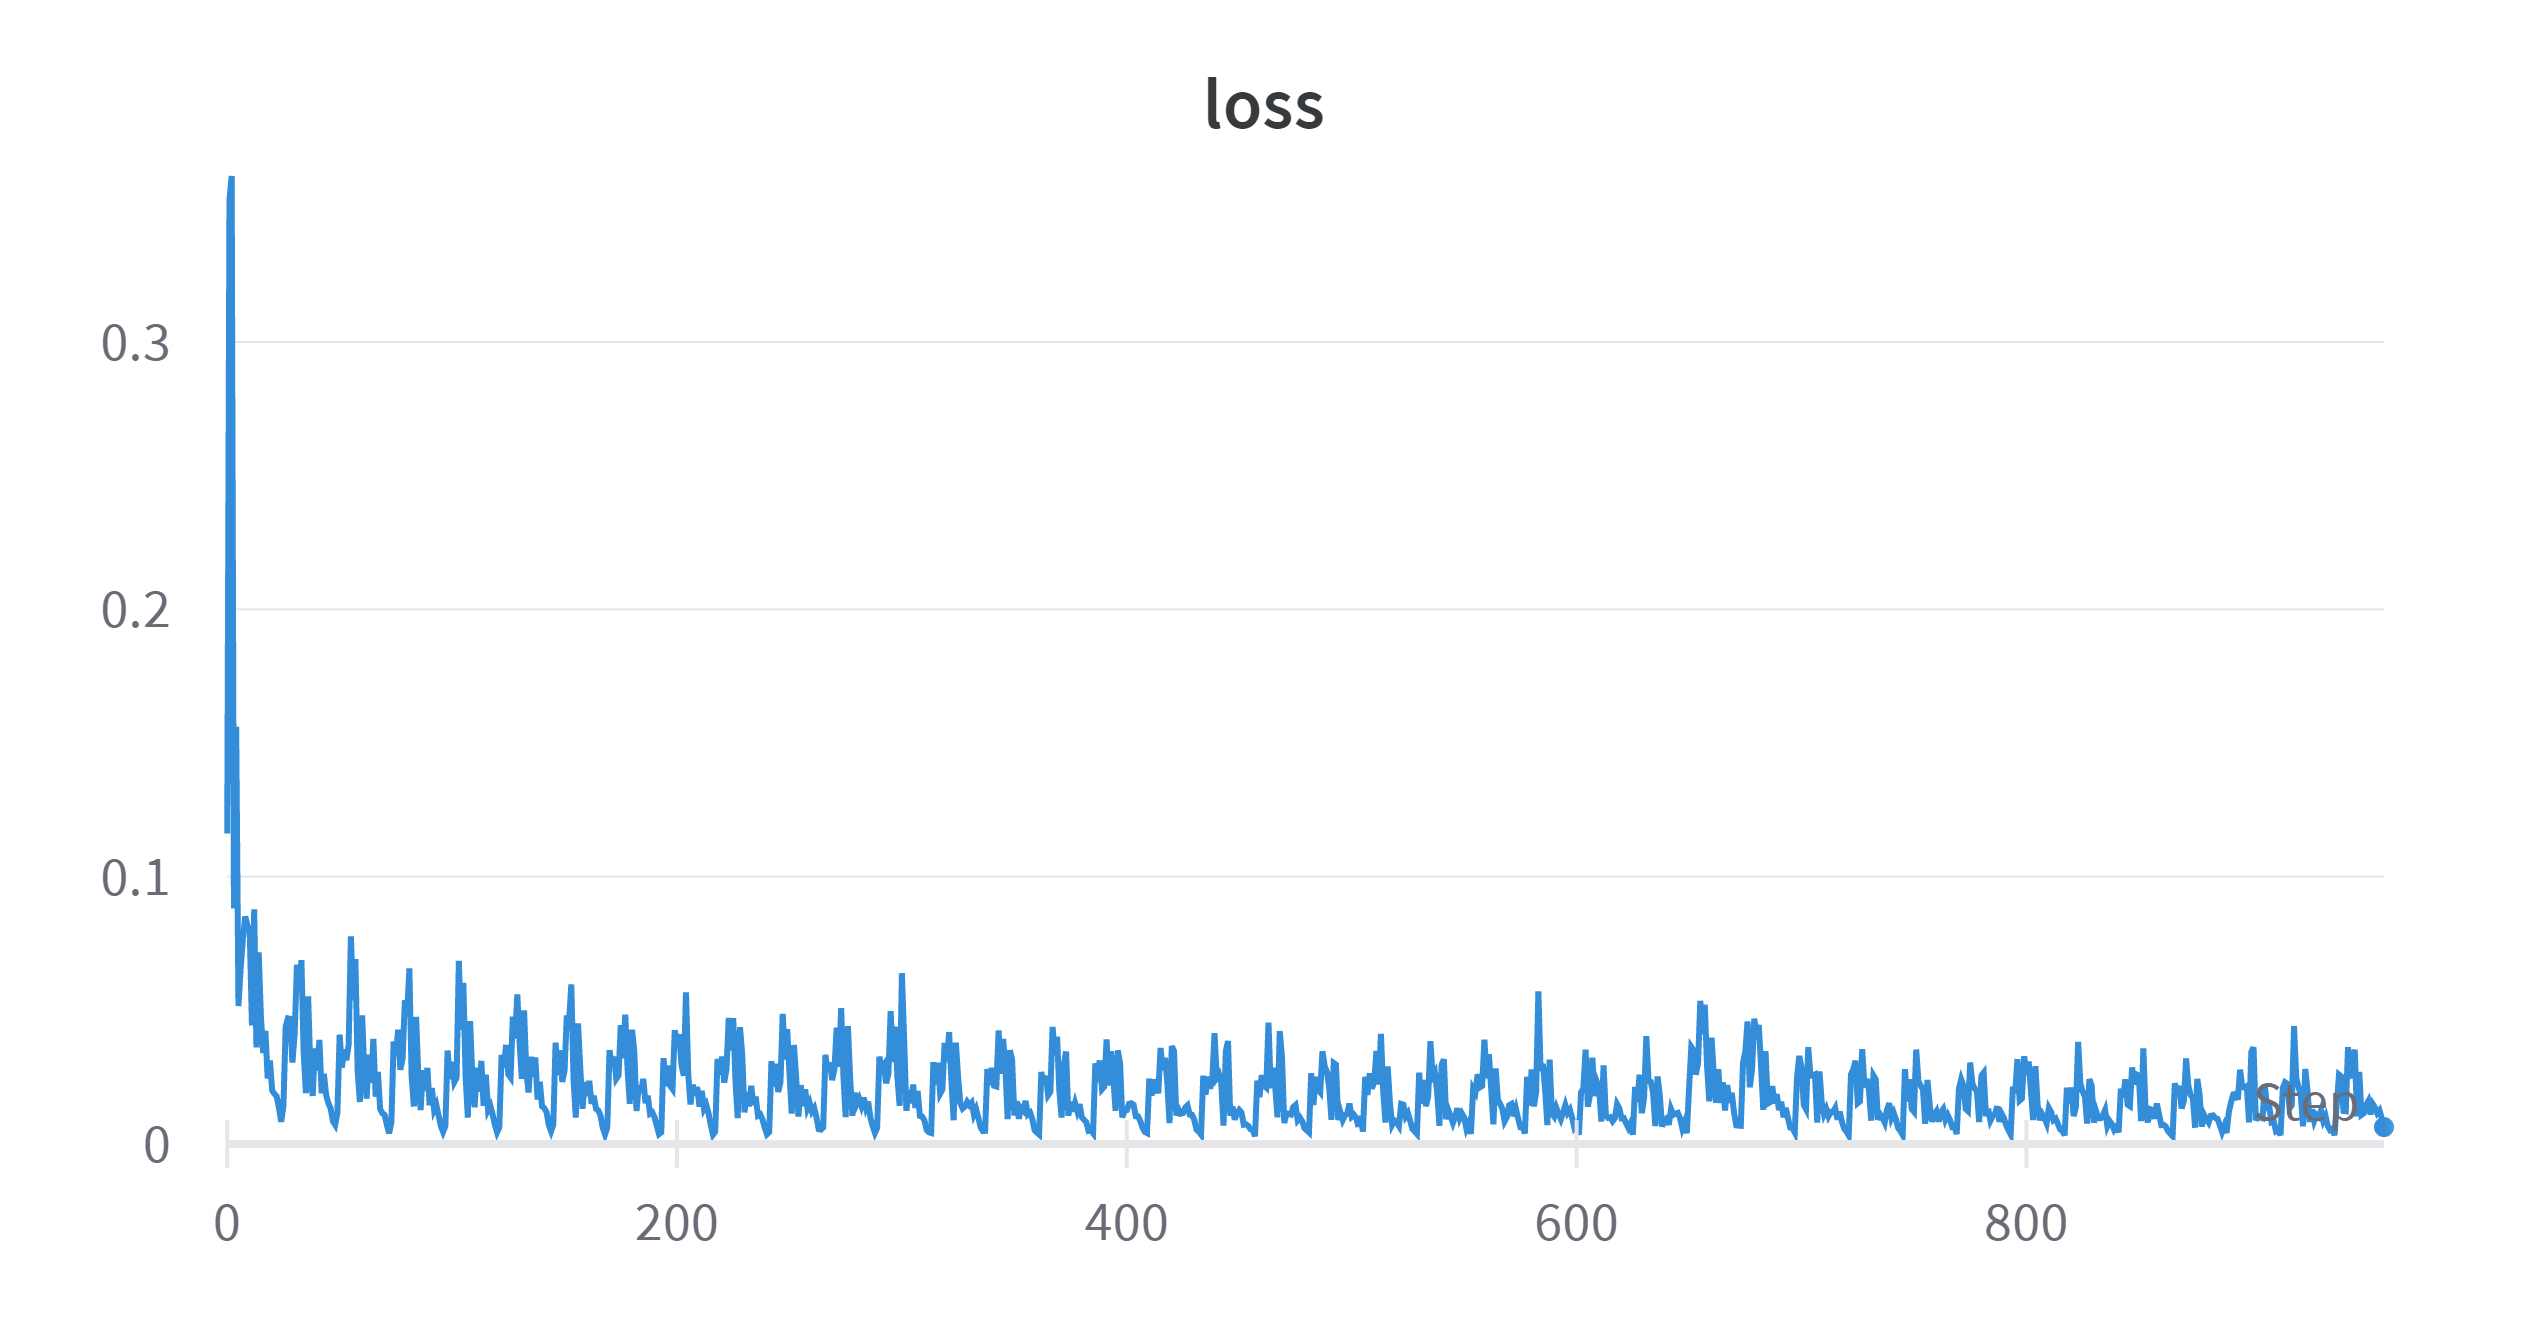

### Prueba

<ipython-input-4-e7c42f624d71>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-4-e7c42f624d71>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


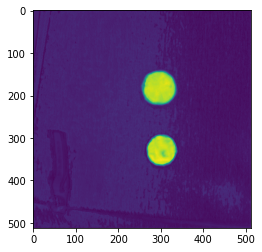

In [ ]:
it = iter(ds_loader)
img, label = next(it)
# print(torch.min(img), torch.max(img))
# print(torch.min(label), torch.max(label))

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())
print("resultado2: resultado 3 resultado 4 resultado 5 resultado 5 resultado 6 resutaldo 7 resultado 8 resultado 9 resultado 10")

## Testeo final de los resultados del modelo

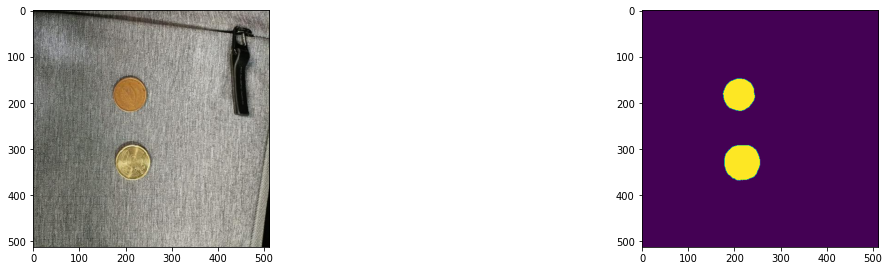

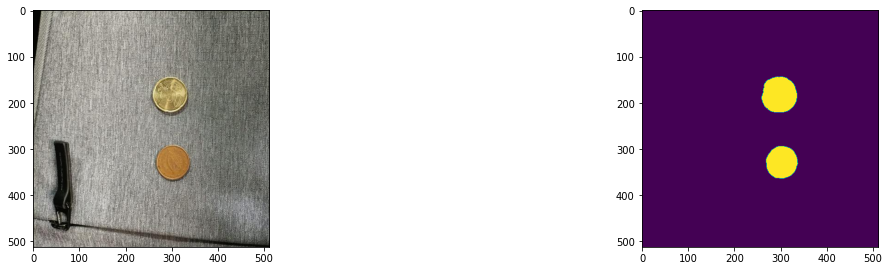

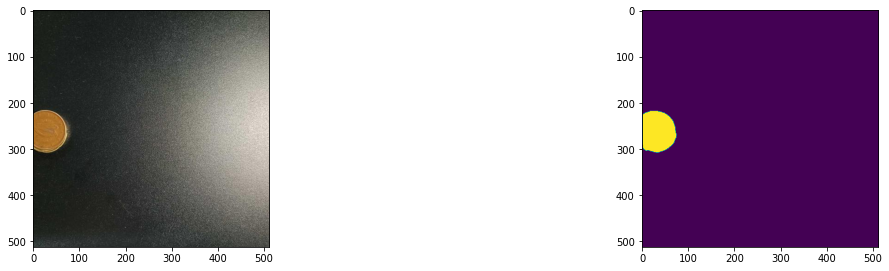

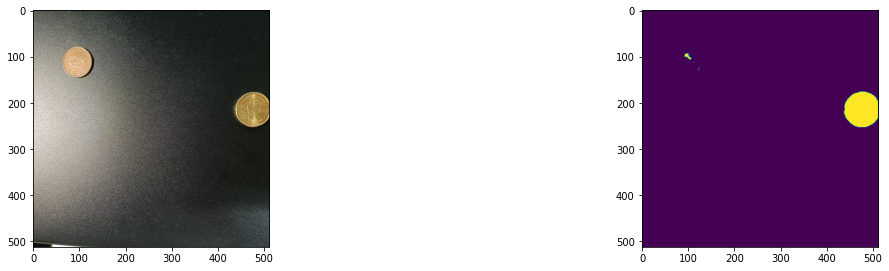

In [ ]:


# Threshold the output
ret = torch.round(ret)

# Show a matrix of images of 4x2 
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy())
    


### Guardado del modelo

In [ ]:
torch.save(model.state_dict(), "model_unet_coins.pth")

NameError: ignored

### Carga del modelo

In [ ]:
model = build_unet().to(device)
model.load_state_dict(torch.load("model_unet_coins.pth"))

<All keys matched successfully>

In [ ]:
ds_test = Dataset("./ImagenesMonedas/test/images", "./ImagenesMonedas/labels")
#print(ds.files)
ds_test_loader = DataLoader(ds_test, batch_size=4)

<ipython-input-4-e7c42f624d71>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-4-e7c42f624d71>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


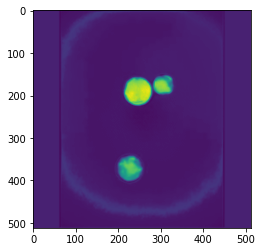

In [ ]:
it_test = iter(ds_test_loader)
img_test, label_test = next(it_test)
# print(torch.min(img), torch.max(img))
# print(torch.min(label), torch.max(label))

model.eval()

ret_test = model(img_test.to(device))
plt.imshow(ret_test[1][0].detach().cpu().numpy())

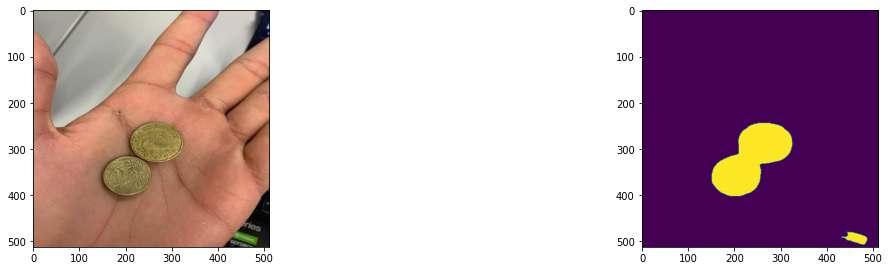

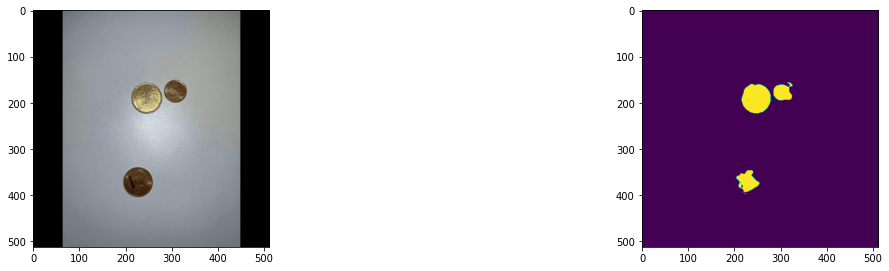

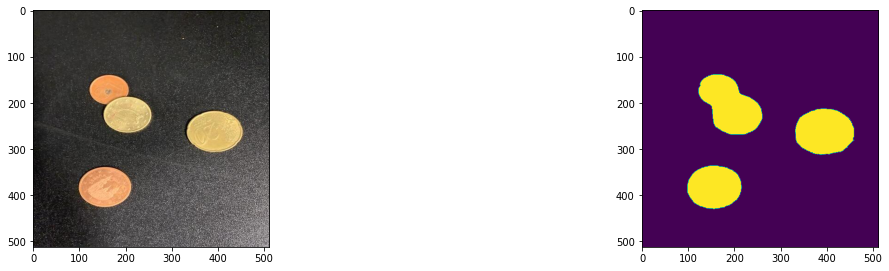

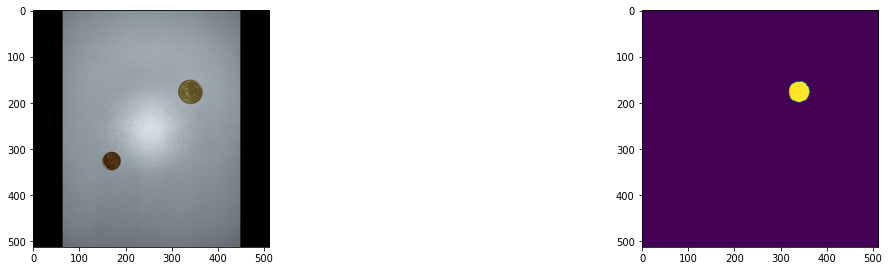

In [ ]:
# Threshold the output
ret_test = torch.round(ret_test)

# Show a matrix of images of 4x2 
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img_test[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret_test[i][0].detach().cpu().numpy())